In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_normal

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=500
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

In [4]:
gpu_id = 'cuda:2'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [ ]:
class SubNet(nn.Module):
    '''
    The subnetwork that is used in LMF for video and audio in the pre-fusion stage
    '''

    def __init__(self, in_size, hidden_size, dropout):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            dropout: dropout probability
        Output:
            (return value in forward) a tensor of shape (batch_size, hidden_size)
        '''
        super(SubNet, self).__init__()
        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, in_size)
        '''
        normed = self.norm(x)
        dropped = self.drop(normed)
        y_1 = F.relu(self.linear_1(dropped))
        y_2 = F.relu(self.linear_2(y_1))
        y_3 = F.relu(self.linear_3(y_2))

        return y_3


class TextSubNet(nn.Module):
    '''
    The LSTM-based subnetwork that is used in LMF for text
    '''

    def __init__(self, in_size, hidden_size, out_size, num_layers=1, dropout=0.2, bidirectional=False):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            num_layers: specify the number of layers of LSTMs.
            dropout: dropout probability
            bidirectional: specify usage of bidirectional LSTM
        Output:
            (return value in forward) a tensor of shape (batch_size, out_size)
        '''
        super(TextSubNet, self).__init__()
        self.rnn = nn.LSTM(in_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, sequence_len, in_size)
        '''
        _, final_states = self.rnn(x)
        h = self.dropout(final_states[0].squeeze())
        y_1 = self.linear_1(h)
        return y_1

In [ ]:
class SubNet(torch.nn.Module):

    def __init__(self, input_dim, hidden_layer_size_1, hidden_layer_size_2) -> None:
        super().__init__()
        self.rnn1_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1,)), dtype=torch.float32))
        self.rnn1_c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1,)), dtype=torch.float32))
        self.rnn2_s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1,)), dtype=torch.float32))
        self.rnn2_c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1,)), dtype=torch.float32))
        self.rnn = torch.nn.LSTM(input_dim, hidden_layer_size_1, batch_first=True, num_layers=2, dropout=0.2)
        #self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1, hidden_layer_size_2)), dtype=torch.float32))
        #self.b1 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (hidden_layer_size_1, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x, text_lens):
        batch_size = x.shape[0]
        
        s0 = torch.stack((
            self.rnn1_s0,
            self.rnn2_s0,
        ), dim=0)
        s0 = s0.unsqueeze(1).tile((1, batch_size, 1))

        c0 = torch.stack((
            self.rnn1_c0,
            self.rnn2_c0,
        ), dim=0)
        c0 = c0.unsqueeze(1).tile((1, batch_size, 1))

        (interm_states, (_, _)) = self.rnn(x, (s0, c0))
        final_state = interm_states[torch.arange(batch_size), text_lens - 1, :]
        #hidden = torch.nn.functional.leaky_relu(final_state@self.w1 + self.b1)
        return final_state@self.w2 + self.b2

In [5]:
class LMF(nn.Module):
    '''
    Low-rank Multimodal Fusion
    '''

    def __init__(self, input_dims, hidden_dims, text_out, dropouts, output_dim, rank, use_softmax=False):
        '''
        Args:
            input_dims - a length-3 tuple, contains (audio_dim, video_dim, text_dim)
            hidden_dims - another length-3 tuple, hidden dims of the sub-networks
            text_out - int, specifying the resulting dimensions of the text subnetwork
            dropouts - a length-4 tuple, contains (audio_dropout, video_dropout, text_dropout, post_fusion_dropout)
            output_dim - int, specifying the size of output
            rank - int, specifying the size of rank in LMF
        Output:
            (return value in forward) a scalar value between -3 and 3
        '''
        super(LMF, self).__init__()

        # dimensions are specified in the order of audio, video and text
        self.audio_in = input_dims[0]
        self.video_in = input_dims[1]
        self.text_in = input_dims[2]

        self.audio_hidden = hidden_dims[0]
        self.video_hidden = hidden_dims[1]
        self.text_hidden = hidden_dims[2]
        self.text_out= text_out
        self.output_dim = output_dim
        self.rank = rank
        self.use_softmax = use_softmax

        self.audio_prob = dropouts[0]
        self.video_prob = dropouts[1]
        self.text_prob = dropouts[2]
        self.post_fusion_prob = dropouts[3]

        # define the pre-fusion subnetworks
        self.audio_subnet = SubNet(self.audio_in, self.audio_hidden, self.audio_prob)
        self.video_subnet = SubNet(self.video_in, self.video_hidden, self.video_prob)
        self.text_subnet = TextSubNet(self.text_in, self.text_hidden, self.text_out, dropout=self.text_prob)

        # define the post_fusion layers
        self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
        # self.post_fusion_layer_1 = nn.Linear((self.text_out + 1) * (self.video_hidden + 1) * (self.audio_hidden + 1), self.post_fusion_dim)
        self.audio_factor = Parameter(torch.Tensor(self.rank, self.audio_hidden + 1, self.output_dim))
        self.video_factor = Parameter(torch.Tensor(self.rank, self.video_hidden + 1, self.output_dim))
        self.text_factor = Parameter(torch.Tensor(self.rank, self.text_out + 1, self.output_dim))
        self.fusion_weights = Parameter(torch.Tensor(1, self.rank))
        self.fusion_bias = Parameter(torch.Tensor(1, self.output_dim))

        # init teh factors
        xavier_normal(self.audio_factor)
        xavier_normal(self.video_factor)
        xavier_normal(self.text_factor)
        xavier_normal(self.fusion_weights)
        self.fusion_bias.data.fill_(0)

    def forward(self, audio_x, video_x, text_x):
        '''
        Args:
            audio_x: tensor of shape (batch_size, audio_in)
            video_x: tensor of shape (batch_size, video_in)
            text_x: tensor of shape (batch_size, sequence_len, text_in)
        '''
        audio_h = self.audio_subnet(audio_x)
        video_h = self.video_subnet(video_x)
        text_h = self.text_subnet(text_x)
        batch_size = audio_h.data.shape[0]

        # next we perform low-rank multimodal fusion
        # here is a more efficient implementation than the one the paper describes
        # basically swapping the order of summation and elementwise product
        if audio_h.is_cuda:
            DTYPE = torch.cuda.FloatTensor
        else:
            DTYPE = torch.FloatTensor

        _audio_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), audio_h), dim=1)
        _video_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), video_h), dim=1)
        _text_h = torch.cat((Variable(torch.ones(batch_size, 1).type(DTYPE), requires_grad=False), text_h), dim=1)

        fusion_audio = torch.matmul(_audio_h, self.audio_factor)
        fusion_video = torch.matmul(_video_h, self.video_factor)
        fusion_text = torch.matmul(_text_h, self.text_factor)
        fusion_zy = fusion_audio * fusion_video * fusion_text

        # output = torch.sum(fusion_zy, dim=0).squeeze()
        # use linear transformation instead of simple summation, more flexibility
        output = torch.matmul(self.fusion_weights, fusion_zy.permute(1, 0, 2)).squeeze() + self.fusion_bias
        output = output.view(-1, self.output_dim)
        if self.use_softmax:
            output = F.softmax(output)
        return output

step error


/tmp/ipykernel_2158468/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2158468/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2158468/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.7095441222190857
dev accuracy: 59.05%
2 0.6782593727111816
dev accuracy: 60.08%
3 0.6358934640884399
dev accuracy: 61.01%
4 0.569202721118927
dev accuracy: 61.21%
5 0.6146436929702759
dev accuracy: 60.49%
6 0.6432384848594666
dev accuracy: 62.76%
7 0.5748285055160522
dev accuracy: 61.63%
8 0.5048037767410278
dev accuracy: 62.14%
9 0.5590681433677673
dev accuracy: 61.21%
10 0.5786247849464417
dev accuracy: 60.19%
11 0.569973349571228
dev accuracy: 61.93%
12 0.5277644395828247
dev accuracy: 60.49%
13 0.38734179735183716
dev accuracy: 60.60%
14 0.43165040016174316
dev accuracy: 61.21%
15 0.26596611738204956
dev accuracy: 63.17%
16 0.26403048634529114
dev accuracy: 60.60%
17 0.2622978389263153
dev accuracy: 61.73%
18 0.27057403326034546
dev accuracy: 59.98%
19 0.21916121244430542
dev accuracy: 60.49%
20 0.2563992142677307
dev accuracy: 58.95%
21 0.15088772773742676
dev accuracy: 60.49%
22 0.05261526629328728
dev accuracy: 61.93%
23 0.10592875629663467
dev accuracy: 58.74%
24 0.09727898

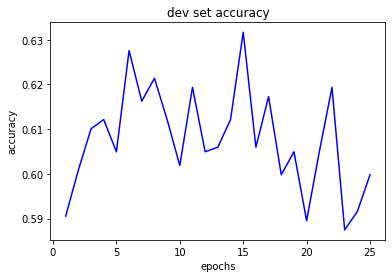

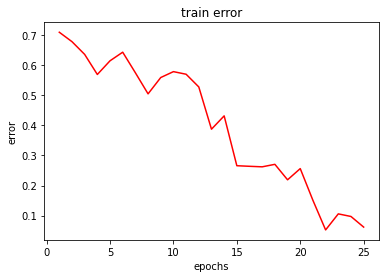

best model after 15 epochs with dev set accuracy 0.6316872239112854


In [7]:
# input features
###
idxs_text = torch.arange(300) # text, 300
idxs_speech = torch.arange(300, 381) # speech, 81
idxs_visual = torch.arange(381, 752) # visual, 371
#idxs = torch.arange(381) # text + speech, 381
#idxs = torch.cat((torch.arange(300), torch.arange(381, 752))) # text + visual, 671
#idxs = torch.arange(300, 752) # speech + visual, 452
#idxs = torch.arange(752) # text + speech + visual, 752

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
rnn = RNN(input_dim_text=300, input_dim_speech=81, input_dim_visual=371, hidden_layer_size=256)
rnn.to(device)

optimiser = torch.optim.Adam(rnn.parameters(), lr=0.001)
epochs = 100
patience = 10

print('step', 'error')
dev_accs = []
best_dev_acc = 0
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = rnn(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(rnn(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

    if acc > best_dev_acc:
        num_bad_epochs = 0
        best_dev_acc = acc
        best_epoch = epoch
        torch.save(rnn, 'punchline_rnn_text_speech_visual.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, num_epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

print('best model after {} epochs with dev set accuracy {}'.format(best_epoch, best_dev_acc))
rnn = torch.load('punchline_rnn_text_speech_visual.pth')

In [13]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(rnn(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p[:, :, idxs_visual], x_p_len))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_2158468/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_2158468/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_2158468/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test accuracy: 62.55%


In [ ]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

329
290
200
161
so had the graduate heard the right one word maybe he would have ended up onstage oh i don't know maybe with these two
as a multi purpose passenger vehicle it is now officially designed for occasional off road use
the good news is i married her the next year
and as the saying goes when angry you will make the best speech you will ever regret
this is why spouses in happy marriages tend to think that their husband or wife looks much better than anyone else thinks that they do

and not long after that he got another request for a copy from the head of the in california who used it as part of her presentation at an international conference on climate change in sacramento last year
i would have told you myself that i was the last person on earth who would stay with a man who beats me but in fact i was a very typical victim because of my age
but on the other side of that predatory gaze is a female husky in a play bow wagging her tail
so when you're watching a movie and a phon